# Causal Discovery on the AI4I Dataset

This notebook applies multiple causal discovery algorithms to the AI4I 2020 predictive maintenance dataset.
We focus on continuous sensor variables and compare constraint-based, score-based, and optimization-based methods.

In [17]:
# Install required libraries
!pip install causal-learn lingam
!pip install git+https://github.com/xunzheng/notears.git

  Cloning https://github.com/xunzheng/notears.git to /tmp/pip-req-build-gcam8t_a
  Running command git clone --filter=blob:none --quiet https://github.com/xunzheng/notears.git /tmp/pip-req-build-gcam8t_a
  Resolved https://github.com/xunzheng/notears.git to commit eb06eaf08ca90501a8caa4062d62466747ba3cec
  Preparing metadata (setup.py) ... done


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading and Preprocessing

We select five continuous variables from the AI4I dataset.
All variables are standardized prior to causal discovery, as required by most algorithms.

In [18]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [19]:
features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

df = df[features].dropna()
df.shape

(10000, 5)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns
)

df_scaled.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588


## PC Algorithm (Constraint-Based)

The PC algorithm infers a causal skeleton using conditional independence tests.
Edges represent statistically supported dependencies; directions may remain partially undetermined.

In [21]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

cg_pc = pc(
    df_scaled.values,
    alpha=0.05,
    indep_test=fisherz
)

cg_pc.G

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
cg_pc.G.graph

array([[ 0, -1,  0,  0,  0],
       [-1,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0],
       [ 0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [23]:
import numpy as np

nodes = df_scaled.columns.tolist()
G = cg_pc.G.graph

edges = []
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if G[i, j] != 0:
            edges.append((nodes[i], nodes[j], G[i, j]))

edges

[('Air temperature [K]', 'Process temperature [K]', np.int64(-1)),
 ('Process temperature [K]', 'Air temperature [K]', np.int64(-1)),
 ('Rotational speed [rpm]', 'Torque [Nm]', np.int64(-1)),
 ('Torque [Nm]', 'Rotational speed [rpm]', np.int64(-1))]

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = df_scaled.columns.tolist()
G = nx.Graph()   # undirected graph (PC result)

G.add_nodes_from(nodes)

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if cg_pc.G.graph[i, j] != 0:
            G.add_edge(nodes[i], nodes[j])

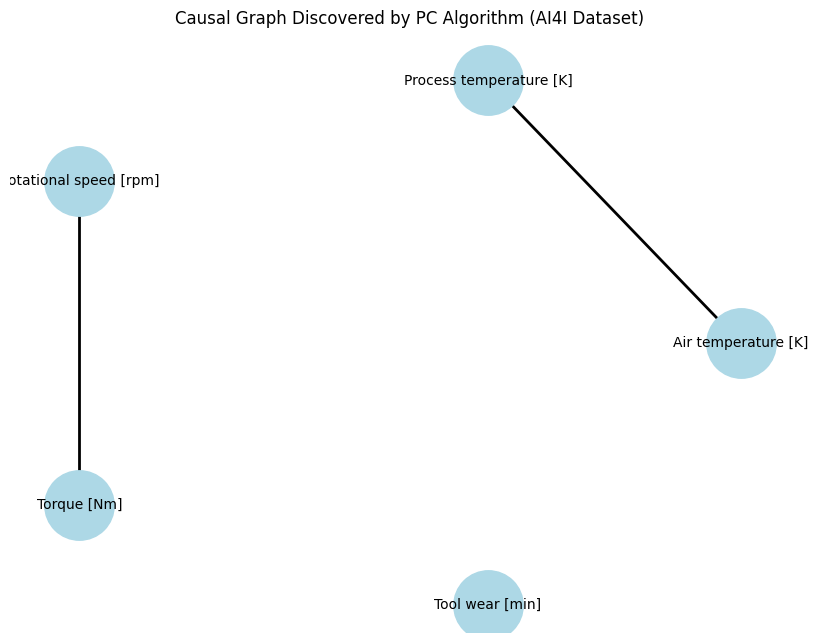

In [25]:
G = nx.Graph()

G.add_nodes_from(nodes)

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if cg_pc.G.graph[i, j] != 0:
            G.add_edge(nodes[i], nodes[j])

plt.figure(figsize=(8, 6))

pos = nx.circular_layout(G)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2500,
    node_color="lightblue",
    font_size=10,
    edge_color="black",
    width=2
)

plt.title("Causal Graph Discovered by PC Algorithm (AI4I Dataset)")
plt.show()

**Observation:**  
The PC algorithm identifies strong dependencies between temperature variables and between rotational speed and torque, while tool wear appears conditionally independent.

## DirectLiNGAM (Functional Causal Model)

DirectLiNGAM assumes linear relationships with non-Gaussian noise and outputs a fully directed DAG.

In [26]:
import lingam

In [27]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [28]:
features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]

df_cont = df[features].dropna()
df_cont.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df_cont)

In [30]:
from lingam import DirectLiNGAM

model = DirectLiNGAM()
model.fit(X)

In [31]:
import numpy as np

B = model.adjacency_matrix_
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.87610716,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.87502709,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [32]:
edges = []
EPS = 0.1   # standard, conservative

for i in range(len(features)):
    for j in range(len(features)):
        if abs(B[i, j]) > EPS:
          edges.append((features[j], features[i], B[i, j]))

edges

[('Air temperature [K]',
  'Process temperature [K]',
  np.float64(0.8761071581166645)),
 ('Rotational speed [rpm]', 'Torque [Nm]', np.float64(-0.8750270862996065))]

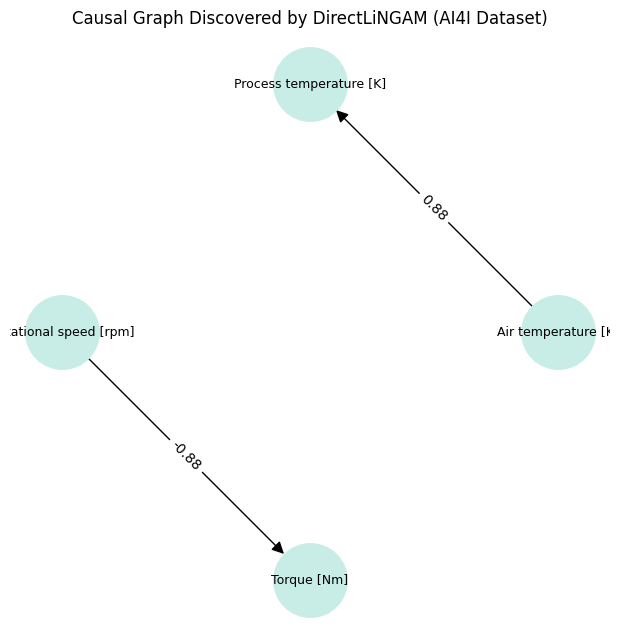

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for cause, effect, weight in edges:
    G.add_edge(cause, effect, weight=round(weight, 2))

plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2800,
    node_color="#C7EDE6",
    font_size=9,
    arrowsize=18
)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Causal Graph Discovered by DirectLiNGAM (AI4I Dataset)")
plt.show()

**Observation:**  
The resulting graph is sparse, indicating that only strong directed effects satisfy the non-Gaussian noise assumption.

## GES (Score-Based)

GES searches for a DAG that optimizes a score function (BIC-like) over equivalence classes.

In [34]:
import numpy as np
from causallearn.search.ScoreBased.GES import ges

X = df_scaled.values
ges_result = ges(X)   # default score is usually BIC-like for continuous

# adjacency matrix (0/1 style)
A = ges_result['G'].graph
A

array([[ 0, -1,  0,  0,  0],
       [-1,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0],
       [ 0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0]])

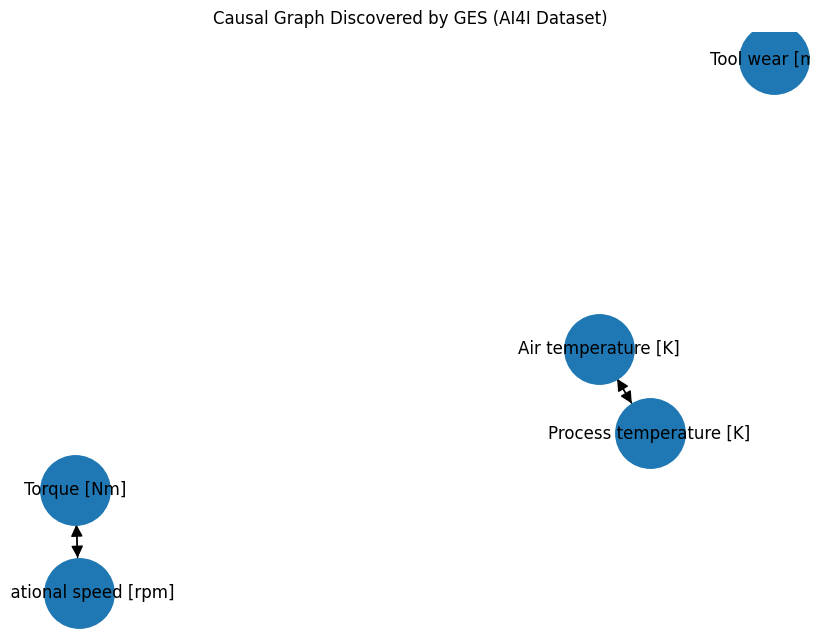

[('Air temperature [K]', 'Process temperature [K]'),
 ('Process temperature [K]', 'Air temperature [K]'),
 ('Rotational speed [rpm]', 'Torque [Nm]'),
 ('Torque [Nm]', 'Rotational speed [rpm]')]

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = df_scaled.columns.tolist()
edges_ges = [(nodes[i], nodes[j]) for i in range(len(nodes)) for j in range(len(nodes)) if A[i, j] != 0]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges_ges)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2500, arrowsize=18)
plt.title("Causal Graph Discovered by GES (AI4I Dataset)")
plt.show()

edges_ges

**Observation:**  
GES identifies bidirectional dependencies between air and process temperature and between rotational speed and torque, reflecting strong mutual associations while leaving tool wear disconnected from the learned structure.

## NOTEARS (Optimization-Based)

NOTEARS formulates causal discovery as a continuous optimization problem with an acyclicity constraint.

In [36]:
from notears.linear import notears_linear
import numpy as np

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/drive/MyDrive/ai4i2020.csv")

features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

df = df[features].dropna()

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns
)

In [38]:
X = df_scaled.values.astype(float)

W = notears_linear(
    X,
    loss_type='l2',   # continuous data
    lambda1=0.1       # sparsity control
)

W

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

nodes = df_scaled.columns.tolist()
G_notears = nx.DiGraph()

EPS = 0.05  # threshold

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if abs(W[i, j]) > EPS:
            G_notears.add_edge(
                nodes[j], nodes[i],
                weight=round(W[i, j], 3)
            )

In [48]:
print("NOTEARS edges:", list(G_notears.edges(data=True)))

NOTEARS edges: []


In [50]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = df_scaled.columns.tolist()
G_notears = nx.DiGraph()

G_notears.add_nodes_from(nodes)

EPS = 0.05

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if abs(W[i, j]) > EPS:
            G_notears.add_edge(
                nodes[j], nodes[i],
                weight=round(W[i, j], 3)
            )

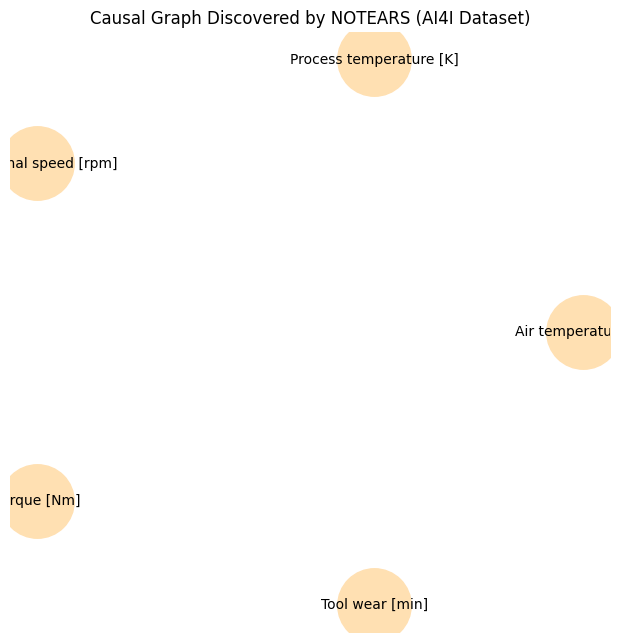

In [51]:
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G_notears)

nx.draw(
    G_notears,
    pos,
    with_labels=True,
    node_size=2800,
    node_color="#FFE0B2",
    font_size=10,
    arrowsize=18
)

plt.title("Causal Graph Discovered by NOTEARS (AI4I Dataset)")
plt.show()

**Observation:**  
NOTEARS returns an empty or near-empty graph, suggesting that no sparse DAG improves the optimization objective under the chosen regularization.
Such outcomes are valid and commonly reported in real-world datasets.

## FCI (Latent Confounders)

FCI extends PC by allowing latent confounders and returns a causal skeleton rather than a fully oriented graph.

In [40]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import fisherz

X = df_scaled.values

# FCI returns (graph, edges)
G_fci, edges_fci = fci(X, indep_test=fisherz, alpha=0.05)

G_fci.graph

  0%|          | 0/5 [00:00<?, ?it/s]

array([[0, 2, 0, 0, 0],
       [2, 0, 0, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0]])

In [41]:
nodes = df_scaled.columns.tolist()
M = G_fci.graph

edges = []
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if M[i, j] != 0:
            edges.append((nodes[i], nodes[j], M[i, j]))
edges[:20], len(edges)

([('Air temperature [K]', 'Process temperature [K]', np.int64(2)),
  ('Process temperature [K]', 'Air temperature [K]', np.int64(2)),
  ('Rotational speed [rpm]', 'Torque [Nm]', np.int64(2)),
  ('Torque [Nm]', 'Rotational speed [rpm]', np.int64(2))],
 4)

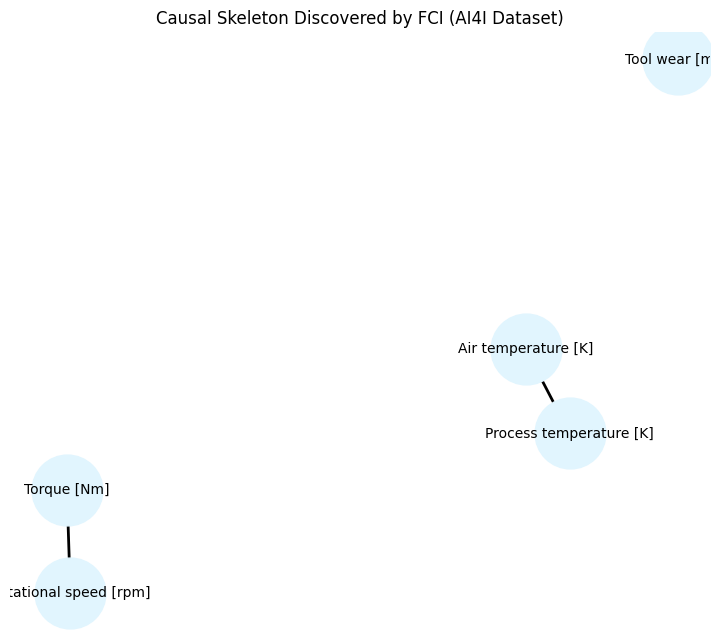

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

nodes = df_scaled.columns.tolist()
M = G_fci.graph

G = nx.Graph()   # UNDIRECTED for FCI
G.add_nodes_from(nodes)

for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if M[i, j] != 0:
            G.add_edge(nodes[i], nodes[j])

plt.figure(figsize=(7, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2600,
    node_color="#E1F5FE",
    font_size=10,
    edge_color="black",
    width=2
)

plt.title("Causal Skeleton Discovered by FCI (AI4I Dataset)")
plt.show()

**Observation:**  
FCI recovers a sparse causal skeleton consistent with PC, indicating robust dependencies between temperature variables and between rotational speed and torque while allowing for the possibility of latent confounders.

## Summary

Across different causal discovery paradigms, consistent dependencies are observed between temperature variables and between rotational speed and torque.
Tool wear does not exhibit strong direct causal relationships under the tested assumptions.
Due to the absence of ground-truth causal structure, results are evaluated qualitatively rather than using accuracy-based metrics.